In [1]:
import pandas as pd
import bz2


dataset = pd.read_csv("train_data", index_col=0)
dataset = dataset.dropna()
dataset = (dataset[(dataset.lang=="en")]).reset_index(drop=True).sort_index()
dataset = dataset.reset_index(drop=True).sort_index()


In [2]:
dataset.head()

,datetime,headline,summary,related,lang,source,priceChangeClass
0,2019-02-18 17:30:06-05:00,Advance Auto Parts Q4 2018 Earnings Preview,No summary available.,AAP,en,Seeking Alpha,0
1,2019-02-19 06:40:42-05:00,"Advance Auto Parts beats by $0.04, revenue in-...",No summary available.,AAP,en,Seeking Alpha,0
2,2019-02-19 06:42:14-05:00,Advance Auto Parts declares $0.06 dividend,No summary available.,AAP,en,Seeking Alpha,0
3,2019-02-19 06:50:47-05:00,Advance Auto Parts lower post Q4 results,No summary available.,AAP,en,Seeking Alpha,0
4,2019-02-19 13:08:09-05:00,"Advance Auto Parts, Inc. (AAP) CEO Tom Greco o...",No summary available.,AAP,en,Seeking Alpha,1


In [3]:
smallest_amount_data = min(dataset.priceChangeClass.value_counts())

indexes = []
for unique_class in set(dataset.priceChangeClass):
        temp_indexes = dataset.loc[dataset.priceChangeClass==unique_class].sample(smallest_amount_data).index
        #print(list(temp_indexes))
        indexes += list(temp_indexes)

In [4]:
# Pick out indexes, shuffle rows, and reset indexes
balanced_dataset = dataset.loc[indexes].sample(frac=1).reset_index(drop=True)
balanced_dataset

,datetime,headline,summary,related,lang,source,priceChangeClass
0,2020-07-08 05:00:00-05:00,KKR To Acquire Global Atlantic Financial Group...,"NEW YORK & HAMILTON, Bermuda--(BUSINESS WIRE)-...",KKR,en,Business Wire,2
1,2020-03-17 16:54:31-05:00,These are the apps that Apple is recommending ...,The coronavirus outbreak that originated in Ch...,SNAP,en,Business Insider,0
2,2019-12-10 10:43:50-05:00,Build-A-Bear Workshop warns revenue could fall...,"Disney's ""Frozen 2"" is making it snow at the b...",DIS,en,Business Insider,1
3,2020-10-06 21:21:06-05:00,WTI drops 2% on dollar strength and bearish US...,"West Texas Intermediate (WTI), a North America...",WTI,en,FXStreet,0
4,2020-09-30 16:45:44-05:00,How one mortgage servicing company is prioriti...,HousingWire spoke with Ocwen Financial Corpora...,OCN,en,HousingWire,2
...,...,...,...,...,...,...,...
195694,2020-12-01 09:08:59-05:00,Bitcoin Cash Price Reflects Slight Decline; Al...,Bitcoin Cash was trading at 5th position for t...,LTC,en,CryptoNewsZ,2
195695,2019-04-06 19:03:00-05:00,Las Vegas Sands Announces Asia Expansion,A big new project is finally on the way from L...,LVS,en,The Motley Fool,2
195696,2020-09-28 06:38:56-05:00,Shale producer Devon Energy to buy peer WPX En...,U.S. oil and gas producer Devon Energy Corp <D...,DVN,en,Reuters UK,2
195697,2020-08-27 03:36:20-05:00,Hindustan Aeronautics down 13% on government's...,"The government will sell about 10% stake, with...",HAL,en,Livemint,1


In [5]:
seed = 12345

val_percent = 0.1
test_percent = 0.2

validation_data = (balanced_dataset.sample(frac=val_percent, random_state=seed)).reset_index(drop=True)
test_data = (balanced_dataset.sample(frac=test_percent, random_state=seed)).reset_index(drop=True)
train_data = (balanced_dataset.iloc[balanced_dataset.index.difference(test_data.index).difference(validation_data.index)]).reset_index(drop=True)

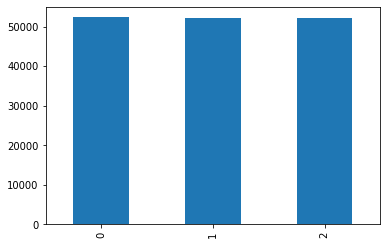

In [6]:
import matplotlib.pyplot as plt
train_data['priceChangeClass'].value_counts().plot(kind='bar');

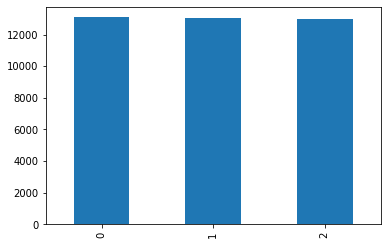

In [7]:
test_data['priceChangeClass'].value_counts().plot(kind='bar');

## Naive Bayes classifier¶

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
steps= [('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())]
pipeline = Pipeline(steps)
pipeline.fit(train_data.summary, train_data.priceChangeClass)

In [9]:
pipeline.score(test_data.summary, test_data.priceChangeClass)

0.5225600408788963

(array([11964.,     0.,     0.,     0.,     0., 15386.,     0.,     0.,
            0., 11790.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

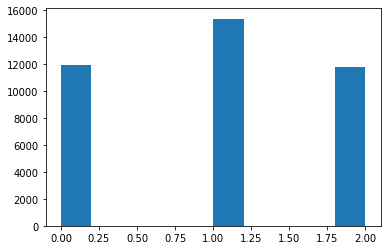

In [10]:
predicted = pipeline.predict(test_data.summary)
plt.hist(predicted)

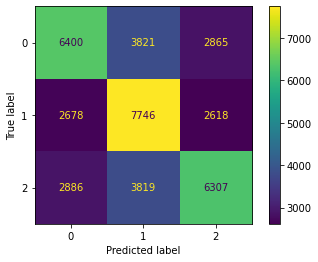

In [11]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(pipeline, test_data.summary, test_data.priceChangeClass)


## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [12]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(train_data.summary, train_data.priceChangeClass)
dummy_clf.score(test_data.summary, test_data.priceChangeClass)

0.3314001021972407

An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [13]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_data.summary, train_data.priceChangeClass)
dummy_clf.score(test_data.summary, test_data.priceChangeClass)



0.3343382728666326

## Problem 4: Creating a balanced data set

## Problem 5: Confusion matrix

In [14]:
from sklearn.model_selection import GridSearchCV

steps= [('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())]
new_pipeline = Pipeline(steps)
#a = GridSearchCV(estimator=new_pipeline, param_grid={"vec__binary": [True, False],"vec__ngram_range":[(1,1), (1,2)], 
#                                                     "multinomialnb__alpha":[1,0.1]})
new_pipeline.fit(train_data.summary, train_data.priceChangeClass)


Pipeline(steps=[('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())])

In [15]:
#print(a.best_params_)
new_pipeline.score(test_data.summary,test_data.priceChangeClass)

0.5225600408788963

## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model. Did you manage to get better results than the ones that you obtained in Problem&nbsp;6? Answer with a short text.

In [24]:
from sklearn.svm import SVC

steps = [('vec', CountVectorizer()), ('svc',  SVC())]

#parameters = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}

pipeline = Pipeline(steps)

#clf = GridSearchCV(pipeline, parameters)
pipeline.fit(train_data.summary[:5000], train_data.priceChangeClass[:5000])


Pipeline(steps=[('vec', CountVectorizer()), ('svc', SVC())])

In [25]:
#print(pipeline.best_params_)
pipeline.score(test_data.summary,test_data.priceChangeClass)

0.3786407766990291

In [81]:
from sklearn.neural_network import MLPClassifier

steps = [('vec', TfidfVectorizer()), ('net',  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,10), random_state=1,max_iter=1500))]
pipeline = Pipeline(steps)
pipeline.fit(train_data.summary, train_data.priceChangeClass)


/home/hugo/.virtualenvs/stock-news/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('vec', TfidfVectorizer()),
                ('net',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15, 10),
                               max_iter=1500, random_state=1,
                               solver='lbfgs'))])

In [82]:
pipeline.score(test_data.summary,test_data.priceChangeClass)

0.7099642309657639

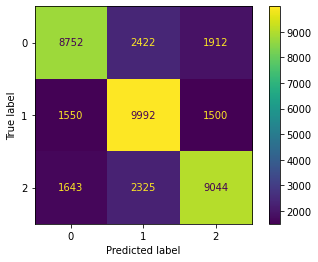

In [83]:
plot_confusion_matrix(pipeline, test_data.summary, test_data.priceChangeClass)

In [84]:
from sklearn.metrics import f1_score,classification_report

res = pipeline.predict(test_data.summary)

print(classification_report(test_data.priceChangeClass, res))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70     13086
           1       0.68      0.77      0.72     13042
           2       0.73      0.70      0.71     13012

    accuracy                           0.71     39140
   macro avg       0.71      0.71      0.71     39140
weighted avg       0.71      0.71      0.71     39140

